<a href="https://colab.research.google.com/github/dolmani38/nash_loss/blob/master/Global%20optimization%20experiment%20of%20game%20theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 게임이론 최적화 알고리즘 

import random
import numpy as np


class Based_on_play_theory_optimizer():

    def __make_strategy(self, number_of_player=10,strategy_range=[-20,20],number_of_strategy=20,resolution=1):
        """
        주어진 player의 수, strategy의 영역, strategy의 개수에 의해 
        전체 pure strategy와 mixed strategy를 생성한다.
        [[[pure,mixed]... ~ number_of_strategy]... ~ number_of_player ]
        .shape = (number_of_player,number_of_strategy,2 (pure,mixed))
        """
        def non_duplicate_randrange(l,h,r,c):
            #lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
            #while (not len(lst[:,0]) == len(set(lst[:,0]))):
            #    lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
            #return lst    
            t = np.ones((c,2))
            x = np.linspace(l, h, c)
            t[:,0] = x[:]
            t[:,1] = 1/c    
            return t    

        S = [non_duplicate_randrange(strategy_range[0],strategy_range[1],resolution,number_of_strategy) for x in range(number_of_player)]
        return np.asarray(S, dtype=np.float64)

    def __choice_strategies(self, strategy_matrix):
        """
        S에서 player들에 대한 전략을 선택 한다.
        선택은 mixed strategy의 확율에 의해..
        """
        return np.asarray([random.choices(population=strategy_matrix[i,:,0],weights=strategy_matrix[i,:,1],k=1) for i in range(strategy_matrix.shape[0])]).reshape(strategy_matrix.shape[0])

    
    def __make_Y_sample(self, strategy_matrix,player=0,p_strategy=0,sample_count = 10):
        """
        player 0의 pure strategy에 대한 (si,Y-i(t)) 생성, 표본 개수 10개
        """
        Y_sample = np.asarray([self.__choice_strategies(strategy_matrix) for i in range(sample_count)])
        Y_sample[:,player] = strategy_matrix[player,p_strategy,0]
        return Y_sample

    def __u_si_Y_i(self, test_function=None,sample_strategies = None):
        """
        (si,Y-i(t))에서 playe 0의 각 pure_strategy에 대한 sample의 f1 평균값 계산 
        """
        y_m = np.asarray([np.mean([test_function(sample_strategies[j,i,:]) for i in range(sample_strategies.shape[1])]) for j in range(sample_strategies.shape[0])])
        return y_m

    def optimize(self,
                 object_function=None,
                 player_count=10,
                 strategy_range=[-20,20],
                 number_of_strategies = 20,
                 sample_count = 10,
                 epoch = 100,
                 resolution=1):
        
        strategy_matrix = self.__make_strategy(player_count,strategy_range,number_of_strategies,resolution)
        history = []
        for t in range(1,epoch+1):
            #Sample strategy 추출
            si_Y_i = np.asarray([[self.__make_Y_sample(strategy_matrix,player=j,p_strategy=i,sample_count = sample_count) for i in range(strategy_matrix.shape[1])] for j in range(strategy_matrix.shape[0])])
            #시행에 대한 best response 추출
            br = np.asarray([strategy_matrix[i,self.__u_si_Y_i(test_function=object_function,sample_strategies = si_Y_i[i,:,:,:]).argmin(),0] for i in range(strategy_matrix.shape[0])])
            #mixed strategy의 갱신
            for i in range(strategy_matrix.shape[0]):
                strategy_matrix[i,:,1] = strategy_matrix[i,:,1]+(1/(t+1))*(((strategy_matrix[i,:,0]==br[i]) * 1) - strategy_matrix[i,:,1])
            #다음 strategy 추출
            s = self.__choice_strategies(strategy_matrix)
            # 목적함수의 값 산출
            mv = object_function(s)
            print("\r{}/{} object_function({})={}               ".format(t,epoch,s,mv), end="", flush=True)
            history.append(mv)
        return strategy_matrix,history,s 


1/100 object_function([  3.15789474   7.36842105   3.15789474  -1.05263158   5.26315789
2/100 object_function([  3.15789474 -15.78947368  -5.26315789 -20.         -20.
3/100 object_function([-20.         -13.68421053   9.47368421 -20.         -20.
4/100 object_function([-17.89473684 -13.68421053   9.47368421 -20.         -20.
5/100 object_function([-20.           3.15789474   9.47368421 -20.           3.15789474
6/100 object_function([-15.78947368 -20.         -17.89473684 -20.         -20.
7/100 object_function([-20.         -15.78947368 -13.68421053 -11.57894737  -1.05263158
8/100 object_function([-17.89473684 -13.68421053 -13.68421053  20.         -20.
9/100 object_function([-20.         -17.89473684 -13.68421053  15.78947368   3.15789474
10/100 object_function([-20.         -20.         -17.89473684 -13.68421053 -20.
11/100 object_function([-15.78947368 -17.89473684 -20.         -13.68421053 -13.68421053
12/100 object_function([-20.         -17.89473684 -15.78947368 -17.89473684 -2

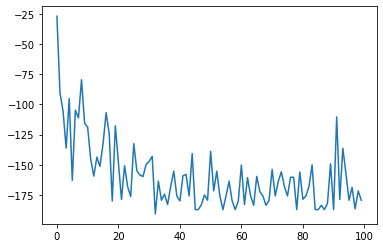

In [68]:
# 실험1
import matplotlib.pyplot as plt
# 논문에서 f1에 해당하는 함수
def f1(player_strategies):
    y = - np.sum(player_strategies* np.sin(np.lib.scimath.sqrt(np.abs(player_strategies))))
    return y

play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(object_function=f1,player_count=10,strategy_range=[-20,20],number_of_strategies=20,sample_count=10,epoch=100,resolution=1)

plt.plot(history)
plt.show()


In [3]:
# 간단한 신경망
# input 3개 node, output 1개 node
# dataset
# 0,0,1 - 0
# 0,1,1 - 0
# 1,0,1 - 1
# 1,1,1 - 1

import numpy as np

# sigmoid function
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0 
#
syn0 = (2*np.random.random((3,1))-1) * 10
print("Initial weights:",syn0)
for iter in range(10000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)

print ("Output After Training:",l1)
print("Weights After Training:",syn0)

Initial weights: [[-1.65955991]
 [ 4.40648987]
 [-9.9977125 ]]
Output After Training: [[0.00254887]
 [0.00750238]
 [0.99270225]
 [0.99752098]]
Weights After Training: [[10.88247479]
 [ 1.08449735]
 [-5.96955506]]


100/100 object_function([ 95.95959596  -1.01010101 -41.41414141])=1.4090917978116712e-18               

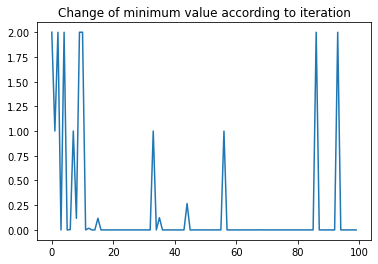

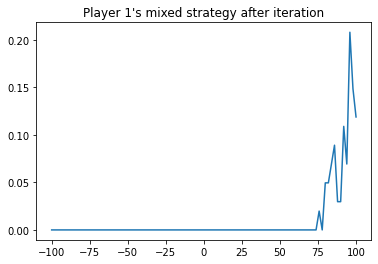

Output After Training: [1.03292053e-18 3.76171264e-19 1.00000000e+00 1.00000000e+00]
Weights After Training: [ 95.95959596  -1.01010101 -41.41414141]


In [35]:
# 게임이론 최적화 알고리즘 에 의한 신경망 test
import matplotlib.pyplot as plt
import numpy as np

# sigmoid function
def nonlin(x):
    return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

def f(syn0):
      # forward propagation
    syn0 = np.array(syn0)
    syn0 = syn0.reshape(syn0.shape[0],1)
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1
    return np.sum(np.abs(l1_error))

play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(object_function=f,player_count=3,strategy_range=[-100,100],number_of_strategies=100,sample_count=10,epoch=100,resolution=1)

plt.plot(history)
plt.title("Change of minimum value according to iteration")
plt.show()

plt.plot(S[0,:,0].reshape(S.shape[1]),S[0,:,1].reshape(S.shape[1]))
plt.title("Player 1's mixed strategy after iteration")
plt.show()    


print("Output After Training:",nonlin(np.dot(l0,op)))
print("Weights After Training:",op)

In [52]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
print(dataset.shape)
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]
# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10)
# evaluate the keras model
yy, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
print('yy:',yy)

(767, 9)
Epoch 1/150
767/767 [==============================] - 0s 197us/step - loss: 4.3804 - accuracy: 0.4146
Epoch 2/150
767/767 [==============================] - 0s 109us/step - loss: 3.1790 - accuracy: 0.4576
Epoch 3/150
767/767 [==============================] - 0s 105us/step - loss: 2.7332 - accuracy: 0.4824
Epoch 4/150
767/767 [==============================] - 0s 101us/step - loss: 2.4303 - accuracy: 0.4876
Epoch 5/150
767/767 [==============================] - 0s 98us/step - loss: 2.0947 - accuracy: 0.5137
Epoch 6/150
767/767 [==============================] - 0s 101us/step - loss: 1.8630 - accuracy: 0.5163
Epoch 7/150
767/767 [==============================] - 0s 99us/step - loss: 1.6161 - accuracy: 0.5489
Epoch 8/150
767/767 [==============================] - 0s 97us/step - loss: 1.4280 - accuracy: 0.5450
Epoch 9/150
767/767 [==============================] - 0s 104us/step - loss: 1.2034 - accuracy: 0.5802
Epoch 10/150
767/767 [==============================] - 0s 100us/st

In [77]:
# 간단한 신경망
# input 8개 node, output 1개 node
# dataset

import numpy as np
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
print(dataset.shape)
X = np.asarray(dataset.iloc[:,0:8])
X = X/np.max(X)
print(X)
y = np.asarray(dataset.iloc[:,8]).reshape(1,len(X)).T
print(X.shape)
print(y.shape)

# sigmoid function
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0 
#
syn0 = (2*np.random.random((8,1))-1) * 10
print("Initial weights:",syn0)
for iter in range(30000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)


print("Weights After Training:",syn0)
l1=l1.round()
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, l1)

print('Accuracy:',accuracy)

#print(l1)

(767, 9)
[[1.18203310e-03 1.00472813e-01 7.80141844e-02 ... 3.14420804e-02
  4.14893617e-04 3.66430260e-02]
 [9.45626478e-03 2.16312057e-01 7.56501182e-02 ... 2.75413712e-02
  7.94326241e-04 3.78250591e-02]
 [1.18203310e-03 1.05200946e-01 7.80141844e-02 ... 3.32151300e-02
  1.97399527e-04 2.48226950e-02]
 ...
 [5.91016548e-03 1.43026005e-01 8.51063830e-02 ... 3.09692671e-02
  2.89598109e-04 3.54609929e-02]
 [1.18203310e-03 1.48936170e-01 7.09219858e-02 ... 3.55791962e-02
  4.12529551e-04 5.55555556e-02]
 [1.18203310e-03 1.09929078e-01 8.27423168e-02 ... 3.59338061e-02
  3.72340426e-04 2.71867612e-02]]
(767, 8)
(767, 1)
Initial weights: [[-1.65955991]
 [ 4.40648987]
 [-9.9977125 ]
 [-3.95334855]
 [-7.06488218]
 [-8.1532281 ]
 [-6.27479577]
 [-3.08878546]]
Weights After Training: [[134.9597165 ]
 [ 14.60375033]
 [-29.44972474]
 [  0.69433896]
 [  0.60594095]
 [ -4.90083161]
 [ 36.9932127 ]
 [-19.03425915]]
Accuracy: 0.7014341590612777


In [0]:
# 게임이론 최적화 알고리즘 에 의한 신경망 test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
print(dataset.shape)
X = np.asarray(dataset.iloc[:,0:8])
X = X/np.max(X)
print(X)
y = np.asarray(dataset.iloc[:,8]).reshape(1,len(X)).T
print(X.shape)
print(y.shape)
# sigmoid function
def nonlin(x):
    return 1/(1+np.exp(-x))
"""    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T
"""
# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

def f(syn0):
      # forward propagation
    syn0 = np.array(syn0)
    syn0 = syn0.reshape(syn0.shape[0],1)
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1
    return np.sum(np.abs(l1_error))

play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(object_function=f,player_count=8,strategy_range=[-200,200],number_of_strategies=1000,sample_count=100,epoch=20,resolution=1)

plt.plot(history)
plt.title("Change of minimum value according to iteration")
plt.show()

plt.plot(S[0,:,0].reshape(S.shape[1]),S[0,:,1].reshape(S.shape[1]))
plt.title("Player 1's mixed strategy after iteration")
plt.show() 
op = np.array(op)
op = op.reshape(op.shape[0],1)
l1 = nonlin(np.dot(X,op))
l1 = l1.round()
#print(l1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, l1)

print('Accuracy:',accuracy)



(767, 9)
[[1.18203310e-03 1.00472813e-01 7.80141844e-02 ... 3.14420804e-02
  4.14893617e-04 3.66430260e-02]
 [9.45626478e-03 2.16312057e-01 7.56501182e-02 ... 2.75413712e-02
  7.94326241e-04 3.78250591e-02]
 [1.18203310e-03 1.05200946e-01 7.80141844e-02 ... 3.32151300e-02
  1.97399527e-04 2.48226950e-02]
 ...
 [5.91016548e-03 1.43026005e-01 8.51063830e-02 ... 3.09692671e-02
  2.89598109e-04 3.54609929e-02]
 [1.18203310e-03 1.48936170e-01 7.09219858e-02 ... 3.55791962e-02
  4.12529551e-04 5.55555556e-02]
 [1.18203310e-03 1.09929078e-01 8.27423168e-02 ... 3.59338061e-02
  3.72340426e-04 2.71867612e-02]]
(767, 8)
(767, 1)
1/20 object_function([ 170.77077077   -2.2022022   198.7987988   -69.06906907 -167.96796797
2/20 object_function([ 157.95795796   49.84984985  -84.68468468 -173.17317317 -174.37437437
  -96.6966967  -110.31031031 -167.56756757])=268.469853007556               